# Follow up post to modeling NFL game outcomes using Python and scikit-learn (and introducing pycaret)

# Intro
This is a follow up to the post I wrote [here](https://www.opensourcefootball.com/posts/2021-01-21-nfl-game-prediction-using-logistic-regression/), with some help from [Tim Bryan](https://www.twitter.com/timbryan000), on modeling NFL game outcomes using scikit-learn. In this post, we set out to improve our model, and introduce a couple more performance metrics (such as examining the ROC curve, precision-recall curve, and confusion matrix) that we didn't have time to touch on. This time, since we're able to reuse a lot of the code, we can spend more time digging in and examining the model.

We also introduce another Python library to help us select our model, PyCaret (recall that last-time we used Logistic Regression but didn't put too much thought in to which was likely to be the best model). PyCaret is an open-source, low-code machine learning library in Python that allows you to train and deploy machine learning models quickly and easily. It was designed to be user-friendly and to reduce the time and effort required to implement machine learning algorithms. PyCaret provides a suite of functions for preprocessing, training, and evaluating machine learning models, as well as tools for model selection and hyperparameter tuning. It also includes features for automatic data visualization and reporting, making it a useful tool for both beginners and experienced machine learning practitioners. Hopefully it can smooth the learning curve for some of the R users who may not be as familiar with Python.

# Recap and model improvements

To recap from last time - we created a Logistic Regression model to predict NFL game outcomes. Our features were based on exponentially-weighted moving averages of a team's own and their opponents EPA metrics. Additionally, we used a dynamic window, building upon [Jack Lichtenstein's work](https://www.opensourcefootball.com/posts/2020-12-29-exploring-rolling-averages-of-epa/), which showed that using a dynamic vs. a static window size was slightly optimal. This dynamic window size worked like this: if we were looking at a game before week 10, we applied a window size = 10 and used some prior season data. For example, if we were looking at a team's point-in-time metrics on week 4, then we'd use weeks 1-3 plus the latest 7 games from the previous season. If we were past week 10, we'd just use an entire season's data. 

The main improvement's Tim and I have made to this project here:

1. We used a different model. This time we use a Ridge Classifier instead of Logistic Regression. We explain the reasoning behind this decision later on in this post.
2. We add another layer to our features by including an adjustment for league average EPA, building upon Jonathan Goldberg's work [here](https://www.opensourcefootball.com/posts/2020-08-20-adjusting-epa-for-strenght-of-opponent/).

Some things have also changed from last time. Instead of using the `nflfastpy` library, we are using `nfl-data-py` library for loading our data source, which comes from nflfastR. `nflfastpy`, which was started by myself has been deprecated, also by myself (I was overambitious in taking on the responsibility to actually maintain that package, truth be told). Thankfully some great folks started up `nfl-data-py` which does what `nflfastpy` did but possibly even better. Great!

# Loading Data

To start off, let's import some dependencies. If you're primarily an R user and want to follow along, I'd suggest using [Google Colab](https://colab.research.google.com/) for an easy and painless setup (you will need to pip install pycaret and nfl_data_py, as these packages are not built-in to the Colab environment).

In [1]:
# import dependencies
import nfl_data_py as nfl

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

Next, we can import our data with `nfl_data_py`. I'm using the IPython magic command here `%%capture` to surpress the cell's output so we don't see `nfl-data-py` telling us when each year has been loaded.

In [2]:
%%capture
# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2000, 2023))

Now let's use the head method just to make sure our data looks correct.

In [3]:
data.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

## Preprocessing

After loading the data, the next step is preprocessing (engineering our features). As discussed, we already made decent headway in the previous post for this part. 

Let's briefly recap what features we chose for our model last time, how we engineered them, and then after, discuss what improvements we are making this time:

First off, our target for this model will be a home team win. All of our features used to predict this target will be derived from EPA. We'll need EPA features that tell us about the home team and away team in each case.

EPA will be split in to defense and offense for both teams, and then further split in to passing and rushing. This means in total, we’ll have 8 features:

1. Home team passing offense EPA/play
2. Home team passing defense EPA/play
3. Home team rushing offense EPA/play
4. Home team rushing defense EPA/play
5. Away team passing offense EPA/play
6. Away team passing defense EPA/play
7. Away team rushing offense EPA/play
8. Away team rushing defense EPA/play

Each of these features will be lagged one period, and then an exponential moving average will be calculated using the dynamic window size we described above. That much gets us back to what we did last time. We are going to paste in the code below to just get us back up to speed (if you want to see detailed descriptions of how the code works it's in the [last post](https://www.opensourcefootball.com/posts/2020-12-29-exploring-rolling-averages-of-epa/); skipping over the explanations for this one).

In [33]:
# Reusing the dynamic window ewma function from the previous post
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]

    return pd.Series(values, index=x.index)

# Seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush'] == 1, :]\
    .groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush'] == 1, :]\
    .groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass'] == 1, :]\
    .groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass'] == 1, :]\
    .groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# Lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
    .apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
    .apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
    .apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
    .apply(dynamic_window_ewma).values

In short, we are now left with 4 DataFrames that we can use to extract our features: `rushing_offense_epa`, `rushing_defense_epa`, `passing_offense_epa`, `passing_defense_epa`. 

You can maybe see where this is going: we are going to be joining these 4 DataFrames together with schedule data to examine each team's EPA figures leading into a matchup. 

Below, we can examine all 4 DataFrames:

In [34]:
display(rushing_offense_epa.head())
display(rushing_defense_epa.head())
display(passing_offense_epa.head())
display(passing_defense_epa.head())

,posteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,-0.483617,NaN,NaN,NaN
1,ARI,2000,2,-0.276743,-0.483617,-0.483617,-0.483617
2,ARI,2000,4,-0.334533,-0.276743,-0.369836,-0.369836
3,ARI,2000,5,-0.058684,-0.334533,-0.355644,-0.355644
4,ARI,2000,6,-0.010326,-0.058684,-0.257809,-0.257809


,defteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,0.146122,NaN,NaN,NaN
1,ARI,2000,2,-0.168889,0.146122,0.146122,0.146122
2,ARI,2000,4,-0.018524,-0.168889,-0.027134,-0.027134
3,ARI,2000,5,-0.022732,-0.018524,-0.023673,-0.023673
4,ARI,2000,6,0.113402,-0.022732,-0.023363,-0.023363


,posteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,0.059045,NaN,NaN,NaN
1,ARI,2000,2,0.660259,0.059045,0.059045,0.059045
2,ARI,2000,4,-0.273369,0.660259,0.389713,0.389713
3,ARI,2000,5,0.049141,-0.273369,0.123158,0.123158
4,ARI,2000,6,0.271449,0.049141,0.098773,0.098773


,defteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,-0.009200,NaN,NaN,NaN
1,ARI,2000,2,0.312221,-0.009200,-0.009200,-0.009200
2,ARI,2000,4,0.427810,0.312221,0.167582,0.167582
3,ARI,2000,5,0.058499,0.427810,0.272192,0.272192
4,ARI,2000,6,-0.120929,0.058499,0.201790,0.201790


Now, for the improvement to our model from last time: we are going to be looking at these 8 features again for use in our model *in excess of league averages*.

First we can refer our `data` DataFrame to get league averages for passing EPA / play and rushing EPA / play.

After we get those averages, we then use the same moving average method (with the same dynamic window method) that we applied to our team-specific EPA metrics and calculate and `ewma` for the league averages as well.

In [35]:
# Create new DataFrames based on team specific epa DataFrames to hold league averages for each EPA category
# Drop the team column and group by season and week
passing_epa_league = data.loc[data['pass_attempt'] == 1].groupby(['season', 'week'], as_index=False)['epa'].mean()
rushing_epa_league = data.loc[data['rush_attempt'] == 1].groupby(['season', 'week'], as_index=False)['epa'].mean()
passing_epa_league['epa_shifted'] = passing_epa_league['epa'].shift()
rushing_epa_league['epa_shifted'] = rushing_epa_league['epa'].shift()

# Add a dynamic EWMA column for the league average
passing_epa_league['ewma_dynamic_window_league'] = passing_epa_league.groupby(['season', 'week'], as_index=False)\
     .apply(dynamic_window_ewma).values

rushing_epa_league['ewma_dynamic_window_league'] = passing_epa_league.groupby(['season', 'week'], as_index=False)\
     .apply(dynamic_window_ewma).values

display(passing_epa_league.head())
display(rushing_epa_league.head())

,season,week,epa,epa_shifted,ewma_dynamic_window_league
0,2000,1,-0.052744,NaN,NaN
1,2000,2,0.082181,-0.052744,-0.052744
2,2000,3,-0.025725,0.082181,0.082181
3,2000,4,-0.010401,-0.025725,-0.025725
4,2000,5,0.055873,-0.010401,-0.010401


,season,week,epa,epa_shifted,ewma_dynamic_window_league
0,2000,1,-0.077850,NaN,NaN
1,2000,2,-0.108246,-0.077850,-0.052744
2,2000,3,-0.076015,-0.108246,0.082181
3,2000,4,-0.143947,-0.076015,-0.025725
4,2000,5,-0.057694,-0.143947,-0.010401


Now that we have the league averages for passing and rushing EPA, we can merge this data back into original EPA dataframes.

In [36]:
# Join the league averages back to the team specific EPA data
rushing_offense_epa = rushing_offense_epa.merge(rushing_epa_league, on=['season', 'week'], how='left', suffixes=('_team', '_league'))

rushing_defense_epa = rushing_defense_epa.merge(rushing_epa_league, on=['season', 'week'], how='left', suffixes=('_team', '_league'))

passing_offense_epa = passing_offense_epa.merge(passing_epa_league, on=['season', 'week'], how='left', suffixes=('_team', '_league'))

passing_defense_epa = passing_defense_epa.merge(passing_epa_league, on=['season', 'week'], how='left', suffixes=('_team', '_league'))

Now, we can group all of these DataFrames together into a single DataFrame we call `epa`, remove the first season of data, and reset our index.

In [51]:
# Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
    .rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
    .rename(columns={'defteam': 'team'})
epa = offense_epa.merge(
    defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#Remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa

,team,season,week,epa_team_rushing_offense,epa_shifted_team_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_league_rushing_offense,epa_shifted_league_rushing_offense,ewma_dynamic_window_league_rushing_offense,epa_team_passing_offense,epa_shifted_team_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_league_passing_offense,epa_shifted_league_passing_offense,ewma_dynamic_window_league_passing_offense,epa_team_rushing_defense,epa_shifted_team_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_league_rushing_defense,epa_shifted_league_rushing_defense,ewma_dynamic_window_league_rushing_defense,epa_team_passing_defense,epa_shifted_team_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense,epa_league_passing_defense,epa_shifted_league_passing_defense,ewma_dynamic_window_league_passing_defense
0,ARI,2001,2,-0.360227,-0.105124,-0.257620,-0.257620,-0.092802,-0.184529,0.015483,0.175296,-0.563326,-0.175331,-0.175331,-0.017557,0.015483,0.015483,-0.007475,0.041494,0.018773,0.018773,-0.092802,-0.184529,0.015483,0.498581,-0.196194,0.111821,0.111821,-0.017557,0.015483,0.015483
1,ARI,2001,3,-0.049025,-0.360227,-0.276913,-0.276913,-0.101250,-0.092802,-0.017557,-0.031840,0.175296,-0.109405,-0.109405,0.043744,-0.017557,-0.017557,-0.072610,-0.007475,0.013838,0.013838,-0.101250,-0.092802,-0.017557,0.583627,0.498581,0.184540,0.184540,0.043744,-0.017557,-0.017557
2,ARI,2001,4,-0.049588,-0.049025,-0.234329,-0.234329,-0.047804,-0.101250,0.043744,0.238713,-0.031840,-0.094911,-0.094911,-0.099274,0.043744,0.043744,0.015773,-0.072610,-0.002316,-0.002316,-0.047804,-0.101250,0.043744,0.014052,0.583627,0.259115,0.259115,-0.099274,0.043744,0.043744
3,ARI,2001,5,-0.575652,-0.049588,-0.199981,-0.199981,-0.070658,-0.047804,-0.099274,0.093899,0.238713,-0.032882,-0.032882,0.060701,-0.099274,-0.099274,-0.001288,0.015773,0.001047,0.001047,-0.070658,-0.047804,-0.099274,-0.113858,0.014052,0.213552,0.213552,0.060701,-0.099274,-0.099274
4,ARI,2001,6,-0.040379,-0.575652,-0.269542,-0.269542,-0.088865,-0.070658,0.060701,0.478186,0.093899,-0.009407,-0.009407,0.010668,0.060701,0.060701,0.029445,-0.001288,0.000615,0.000615,-0.088865,-0.070658,0.060701,-0.075686,-0.113858,0.152927,0.152927,0.010668,0.060701,0.060701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11649,WAS,2022,9,0.076179,-0.241421,-0.108892,-0.108892,0.023532,0.030705,0.012630,-0.242314,0.040192,-0.075413,-0.075413,-0.064505,0.012630,0.012630,-0.267542,-0.266078,-0.158079,-0.158079,0.023532,0.030705,0.012630,0.051542,0.016478,0.050929,0.050929,-0.064505,0.012630,0.012630
11650,WAS,2022,10,0.063594,0.076179,-0.075243,-0.075243,-0.022920,0.023532,-0.064505,0.058256,-0.242314,-0.105758,-0.105758,0.060785,-0.064505,-0.064505,0.092492,-0.267542,-0.177981,-0.177981,-0.022920,0.023532,-0.064505,-0.260651,0.051542,0.051040,0.051040,0.060785,-0.064505,-0.064505
11651,WAS,2022,11,-0.137798,0.063594,-0.050000,-0.052450,-0.096718,-0.022920,0.060785,0.058351,0.058256,-0.075938,-0.076421,0.036848,0.060785,0.060785,-0.504643,0.092492,-0.128804,-0.130164,-0.096718,-0.022920,0.060785,-0.355776,-0.260651,-0.005631,0.002442,0.036848,0.060785,0.060785
11652,WAS,2022,12,0.101007,-0.137798,-0.065963,-0.067271,-0.017713,-0.096718,0.036848,0.035545,0.058351,-0.051521,-0.055683,0.051490,0.036848,0.036848,0.172282,-0.504643,-0.197139,-0.188580,-0.017713,-0.096718,0.036848,-0.181549,-0.355776,-0.069294,-0.046631,0.051490,0.036848,0.036848


## Visualization

Our features are almost fully engineered at this point (we only have one step which is to calculate the adjusted EPA numbers). Quickly before, though, it'd be fun to visualize league average for passing EPA / play and each team's individual passing offense EPA / play for a sample week.

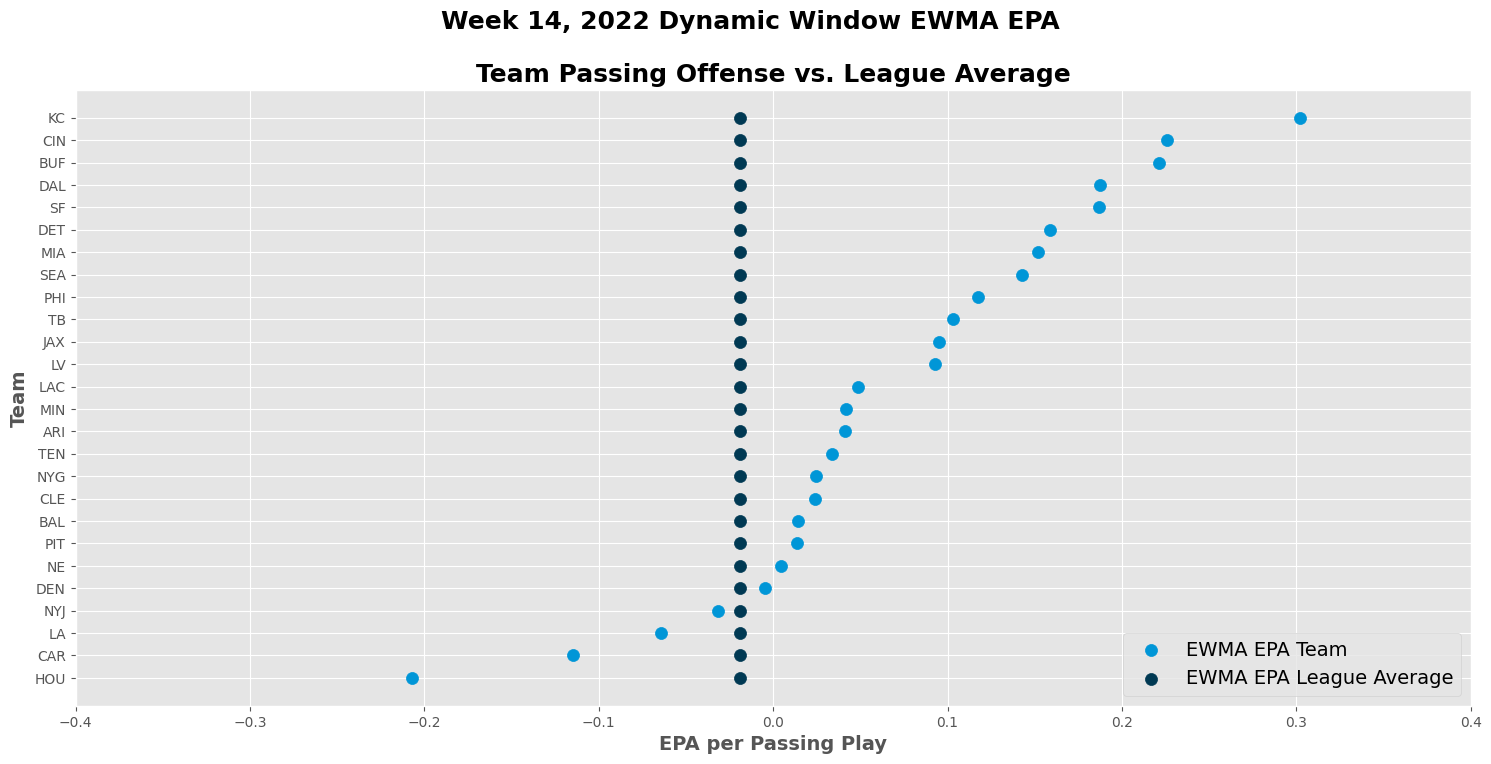

In [57]:
# Create an example DataFrame to visualize week 14, 2022 data
df_vis = epa.loc[(epa['season'] == 2022) & (epa['week'] == 14), :]
df_vis = df_vis.sort_values(by='ewma_dynamic_window_passing_offense', ascending=True)
df_vis = df_vis.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(
    df_vis['ewma_dynamic_window_passing_offense'], df_vis['team'], color='#0096d7', s=75, label='EWMA EPA Team', zorder=3
)
ax.scatter(
    df_vis['ewma_dynamic_window_league_passing_offense'], df_vis['team'], color='#003953', s=75, label='EWMA EPA League Average', zorder=3
)

ax.legend(loc='lower right', fontsize=14)
fig.suptitle('Week 14, 2022 Dynamic Window EWMA EPA', fontsize=18, fontweight='bold')
ax.set_title('Team Passing Offense vs. League Average', fontsize=18, fontweight='bold')
ax.set_xlabel('EPA per Passing Play', fontsize=14, fontweight='bold')
ax.set_ylabel('Team', fontsize=14, fontweight='bold')
ax.set_xlim([-0.4, 0.4]);

## Final Bit of Preprocessing

Finally, we can come up with our adjused EPA / play figures by subtracting out the league averages to each of our 4 EPA categories.

In [58]:
# Create league adjusted EPA columns by subtracting the league average from the team specific EPA
epa['ewma_dynamic_window_rushing_offense_adjusted'] = epa['ewma_dynamic_window_rushing_offense'] - epa['ewma_dynamic_window_league_rushing_offense']
epa['ewma_dynamic_window_passing_offense_adjusted'] = epa['ewma_dynamic_window_passing_offense'] - epa['ewma_dynamic_window_league_passing_offense']
epa['ewma_dynamic_window_rushing_defense_adjusted'] = epa['ewma_dynamic_window_rushing_defense'] - epa['ewma_dynamic_window_league_rushing_defense']
epa['ewma_dynamic_window_passing_defense_adjusted'] = epa['ewma_dynamic_window_passing_defense'] - epa['ewma_dynamic_window_league_passing_defense']

# Leave only the adjusted columns
epa = epa[['team', 'season', 'week', 'ewma_dynamic_window_rushing_offense_adjusted', 'ewma_dynamic_window_passing_offense_adjusted', 'ewma_dynamic_window_rushing_defense_adjusted', 'ewma_dynamic_window_passing_defense_adjusted']]
epa

,team,season,week,ewma_dynamic_window_rushing_offense_adjusted,ewma_dynamic_window_passing_offense_adjusted,ewma_dynamic_window_rushing_defense_adjusted,ewma_dynamic_window_passing_defense_adjusted
0,ARI,2001,2,-0.273104,-0.190814,0.003290,0.096338
1,ARI,2001,3,-0.259355,-0.091848,0.031395,0.202098
2,ARI,2001,4,-0.278073,-0.138655,-0.046060,0.215371
3,ARI,2001,5,-0.100707,0.066392,0.100321,0.312826
4,ARI,2001,6,-0.330243,-0.070107,-0.060086,0.092226
...,...,...,...,...,...,...,...
11649,WAS,2022,9,-0.121522,-0.088043,-0.170709,0.038299
11650,WAS,2022,10,-0.010738,-0.041254,-0.113476,0.115545
11651,WAS,2022,11,-0.113235,-0.137205,-0.190949,-0.058343
11652,WAS,2022,12,-0.104119,-0.092531,-0.225428,-0.083479


Similar to last time, we'll merge schedule data with our `epa` DataFrame, assign home teams and away teams and come up with our target variable, a home team win.

In [60]:
# Create schedule DataFrame and merge in the EPA data
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
    .drop_duplicates().reset_index(drop=True)\
    .assign(home_team_win=lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
    .merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,away_team,home_score,away_score,home_team_win,ewma_dynamic_window_rushing_offense_adjusted_home,ewma_dynamic_window_passing_offense_adjusted_home,ewma_dynamic_window_rushing_defense_adjusted_home,ewma_dynamic_window_passing_defense_adjusted_home,ewma_dynamic_window_rushing_offense_adjusted_away,ewma_dynamic_window_passing_offense_adjusted_away,ewma_dynamic_window_rushing_defense_adjusted_away,ewma_dynamic_window_passing_defense_adjusted_away
0,2001,1,SF,ATL,16,13,1,0.395251,0.695479,0.587112,0.537260,0.362731,0.300996,0.444754,0.607777
1,2001,1,MIN,CAR,13,24,0,0.528081,0.594307,0.425830,0.858287,0.321901,0.428410,0.438516,0.668296
2,2001,1,BAL,CHI,17,6,1,0.383501,0.422326,0.215872,0.177565,0.376956,0.442502,0.405084,0.497107
3,2001,1,GB,DET,28,6,1,0.512868,0.576140,0.432461,0.509847,0.457454,0.338971,0.402931,0.439329
4,2001,1,NYJ,IND,24,45,0,0.288748,0.438962,0.384680,0.305436,0.452073,0.735817,0.540079,0.479071


# First try at a model: Logistic Regression

We're ready to start training and evaluating different models. Here, we'll start out with Logistic Regression the same as last time.

In [63]:
# Define the target variable as home_team_win and the adjust EPA columns as features
target = 'home_team_win'
features = ['ewma_dynamic_window_rushing_offense_adjusted_home', 'ewma_dynamic_window_passing_offense_adjusted_home', 'ewma_dynamic_window_rushing_defense_adjusted_home', 'ewma_dynamic_window_passing_defense_adjusted_home', 'ewma_dynamic_window_rushing_offense_adjusted_away', 'ewma_dynamic_window_passing_offense_adjusted_away', 'ewma_dynamic_window_rushing_defense_adjusted_away', 'ewma_dynamic_window_passing_defense_adjusted_away']

# Create features and target variables, drop any rows with missing values, and fit a logistic regression model
df = df.dropna()

X = df.loc[df['season'] != 2022, features].values
y = df.loc[df['season'] != 2022, target].values

clf = LogisticRegression()
clf.fit(X, y)

# Print accuracy and log loss scores
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))
print('Neg log loss:', np.mean(log_losses))

Model Accuracy: 0.6331481023337838
Neg log loss: -0.6376029424407903


It looks like our model didn't change much using the two performance metrics we used last time (accuracy and neg log loss). Recall that we looked at accuracy to tell us how the model would fare as a straight up pick-em model and neg log loss to evaluate how the model would fare as a win probability model. For both of these metrics, we got more or less the same exact result so not a huge improvement using these new features yet. 

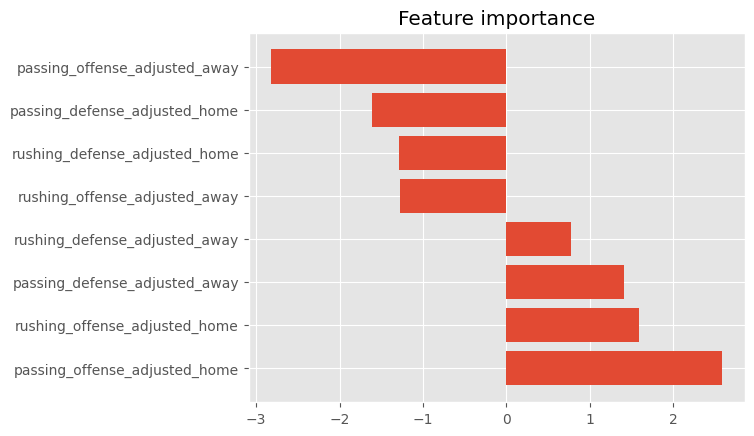

In [62]:
# Visualize feature importance
fig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:])
                 for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(
    zip(feature_names, coef_), key=lambda x: x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted)
plt.show()


## Machine Learning (PyCaret)

In [19]:
# Drop the home and away scores for predictions
df = df.drop(columns=['home_score', 'away_score'])

In [20]:
# Initialize PyCaret
from pycaret.classification import *
exp_clf101 = setup(data=df, target='home_team_win', session_id=456)

,Description,Value
0,session_id,456
1,Target,home_team_win
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5826, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [21]:
# Compare the various classification models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.6319,0.6657,0.7112,0.6538,0.6809,0.2477,0.2493,0.1160
gbc,Gradient Boosting Classifier,0.6265,0.6663,0.7240,0.6445,0.6818,0.2334,0.2358,0.3370
rf,Random Forest Classifier,0.6233,0.6653,0.7209,0.6420,0.6791,0.2269,0.2293,0.2080
lda,Linear Discriminant Analysis,0.6229,0.6676,0.7182,0.6420,0.6779,0.2264,0.2286,0.0320
ridge,Ridge Classifier,0.6221,0.0000,0.7200,0.6408,0.6780,0.2244,0.2268,0.0200
lightgbm,Light Gradient Boosting Machine,0.6145,0.6518,0.6930,0.6397,0.6651,0.2127,0.2139,0.0710
et,Extra Trees Classifier,0.6045,0.6379,0.6939,0.6291,0.6597,0.1901,0.1915,0.1980
nb,Naive Bayes,0.5844,0.6211,0.5643,0.6406,0.5997,0.1711,0.1727,0.0130
lr,Logistic Regression,0.5831,0.5609,0.8900,0.5902,0.7005,0.0952,0.0962,0.8820
qda,Quadratic Discriminant Analysis,0.5564,0.5864,0.4874,0.6188,0.5241,0.1264,0.1289,0.0280


In [25]:
# Create a model using the best performing model
ada = create_model('ada')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6054,0.6423,0.6947,0.6305,0.6611,0.1916,0.1928
1,0.6373,0.6931,0.7168,0.6585,0.6864,0.2580,0.2593
2,0.6667,0.7067,0.7743,0.6731,0.7202,0.3130,0.3177
3,0.6471,0.6761,0.6903,0.6783,0.6842,0.2843,0.2843
4,0.6422,0.6807,0.7200,0.6612,0.6894,0.2692,0.2706
5,0.6201,0.6246,0.7200,0.6378,0.6764,0.2205,0.2229
6,0.6275,0.6636,0.6578,0.6637,0.6607,0.2477,0.2477
7,0.6127,0.6500,0.7022,0.6345,0.6667,0.2075,0.2090
8,0.6364,0.6713,0.7111,0.6584,0.6838,0.2575,0.2586


In [27]:
# Tune the model
tuned_ada = tune_model(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6201,0.6373,0.7522,0.6320,0.6869,0.2132,0.2184
1,0.6642,0.6972,0.7876,0.6667,0.7221,0.3053,0.3121
2,0.6520,0.7148,0.7876,0.6544,0.7149,0.2780,0.2859
3,0.6495,0.6710,0.7345,0.6667,0.6989,0.2819,0.2838
4,0.6078,0.6723,0.7244,0.6245,0.6708,0.1925,0.1957
5,0.6152,0.6367,0.7378,0.6288,0.6789,0.2064,0.2105
6,0.6373,0.6516,0.7422,0.6498,0.6929,0.2546,0.2579
7,0.6225,0.6676,0.7111,0.6426,0.6751,0.2276,0.2292
8,0.6364,0.6798,0.7511,0.6475,0.6955,0.2503,0.2546


## ROC & Precision-Recall Curves

In the context of binary classification (where the model predicts if an input belongs to one of two classes), an ROC curve plots the true positive rate (also called the sensitivity) against the false positive rate (also called the specificity) of a classifier at different classification thresholds.

A classifier that makes random predictions will have an ROC curve that looks like a diagonal line from the bottom left to the top right of the plot, because its true positive and false positive rates will be equal. A perfect classifier, on the other hand, will have an ROC curve that looks like a step function, with a true positive rate of 1 and a false positive rate of 0 for all classification thresholds.

The area under the ROC curve (AUC) is a common metric for evaluating the performance of a binary classifier. A classifier with a high AUC will have a ROC curve that is closer to the top left corner of the plot (indicating a high true positive rate and a low false positive rate), while a classifier with a low AUC will have an ROC curve that is closer to the diagonal line (indicating a lower true positive rate and a higher false positive rate).

In the context of predicting whether or not the home team will win in an NFL game, the precision of the classifier would be the fraction of games that the classifier predicted the home team would win and that the home team actually won. The recall of the classifier, on the other hand, would be the fraction of games where the home team actually won that the classifier was able to correctly identify.

A precision-recall curve plots the precision of a classifier against its recall at different classification thresholds. For example, a classifier that always predicts that the home team will win will have a precision of 100% at a recall of 0%, because it will never make any false predictions. On the other hand, a classifier that only predicts the home team will win when it is very confident will have a lower precision at a higher recall, because it will make more false predictions but also be able to identify more actual positive examples.

The area under the precision-recall curve (AUPR) is a common metric for evaluating the performance of a binary classifier. A classifier with a high AUPR will have a precision-recall curve that is closer to the top right corner of the plot (indicating a high precision and a high recall), while a classifier with a low AUPR will have a precision-recall curve that is closer to the diagonal line (indicating a lower precision and a lower recall).

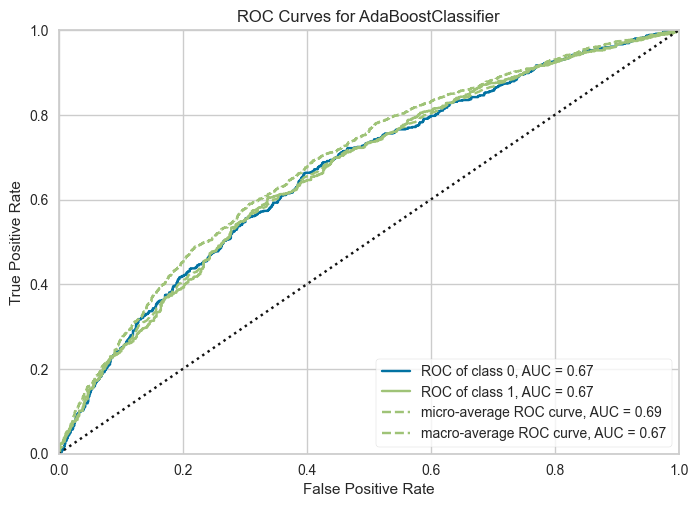

In [28]:
# Plot the ROC curve
plot_model(tuned_ada, plot='auc')

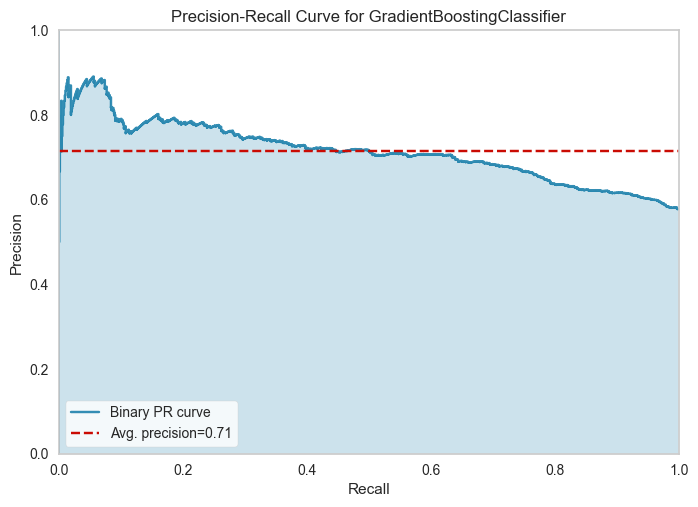

In [ ]:
# Plot the precision recall curve
plot_model(tuned_ada, plot='pr')

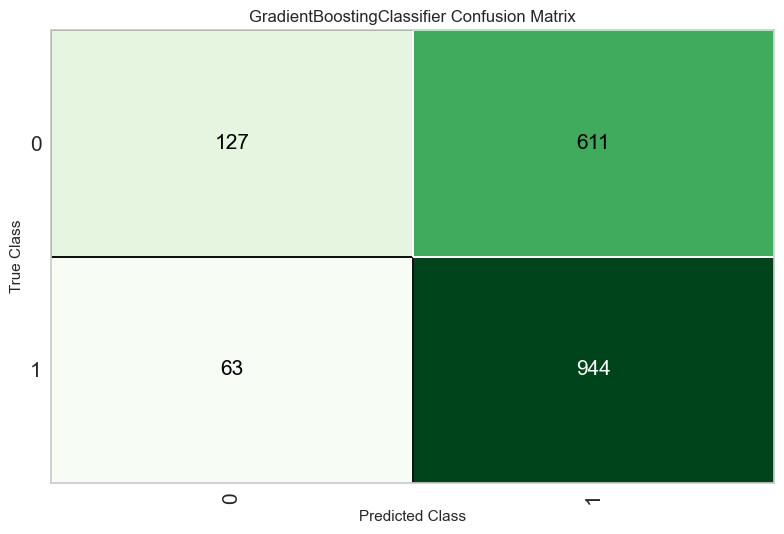

In [ ]:
# Plot the confusion matrix
plot_model(tuned_ada, plot='confusion_matrix')